# Porto Seguro Safe Driver Prediction

This notebook implements a comprehensive solution for predicting whether a driver will file an insurance claim in the next year. We'll explore the data, implement various machine learning models including a custom logistic regression, and evaluate their performance.

## 1. Import Libraries and Load Data

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
# Add these imports at the top of your notebook
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [2]:
# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Display basic information
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display first few rows of training data
train_data.head()

Train data shape: (595212, 59)
Test data shape: (892816, 58)
Sample submission shape: (892816, 2)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Check for missing values (indicated by -1 in this dataset)
missing_train = (train_data == -1).sum().sort_values(ascending=False)
missing_test = (test_data == -1).sum().sort_values(ascending=False)

print("Missing values in training data:")
print(missing_train[missing_train > 0])
print("\nMissing values in test data:")
print(missing_test[missing_test > 0])

Missing values in training data:
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_reg_03        107772
ps_car_14         42620
ps_car_07_cat     11489
ps_ind_05_cat      5809
ps_car_09_cat       569
ps_ind_02_cat       216
ps_car_01_cat       107
ps_ind_04_cat        83
ps_car_02_cat         5
ps_car_11             5
ps_car_12             1
dtype: int64

Missing values in test data:
ps_car_03_cat    616911
ps_car_05_cat    400359
ps_reg_03        161684
ps_car_14         63805
ps_car_07_cat     17331
ps_ind_05_cat      8710
ps_car_09_cat       877
ps_ind_02_cat       307
ps_car_01_cat       160
ps_ind_04_cat       145
ps_car_02_cat         5
ps_car_11             1
dtype: int64


Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64
Percentage of positive class: 3.64%


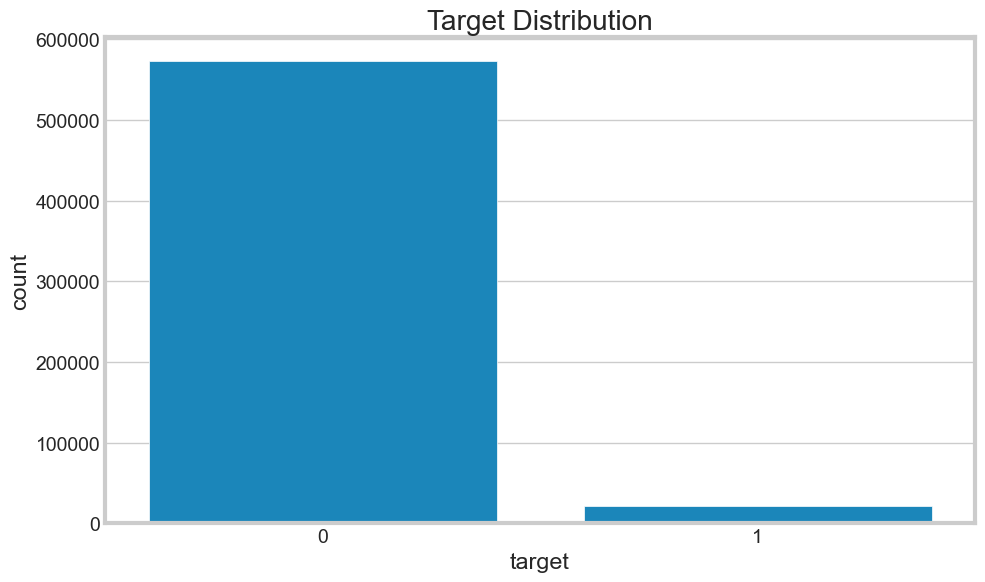

In [4]:
# Target distribution analysis
target_counts = train_data['target'].value_counts()
print(f"Target distribution:\n{target_counts}")
print(f"Percentage of positive class: {target_counts[1] / len(train_data) * 100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=train_data)
plt.title('Target Distribution')
plt.show()

In [5]:
# Explore feature types
binary_features = [col for col in train_data.columns if '_bin' in col]
categorical_features = [col for col in train_data.columns if '_cat' in col]
other_features = [col for col in train_data.columns if col not in binary_features + categorical_features + ['id', 'target']]

print(f"Number of binary features: {len(binary_features)}")
print(f"Number of categorical features: {len(categorical_features)}")
print(f"Number of other features: {len(other_features)}")

Number of binary features: 17
Number of categorical features: 14
Number of other features: 26


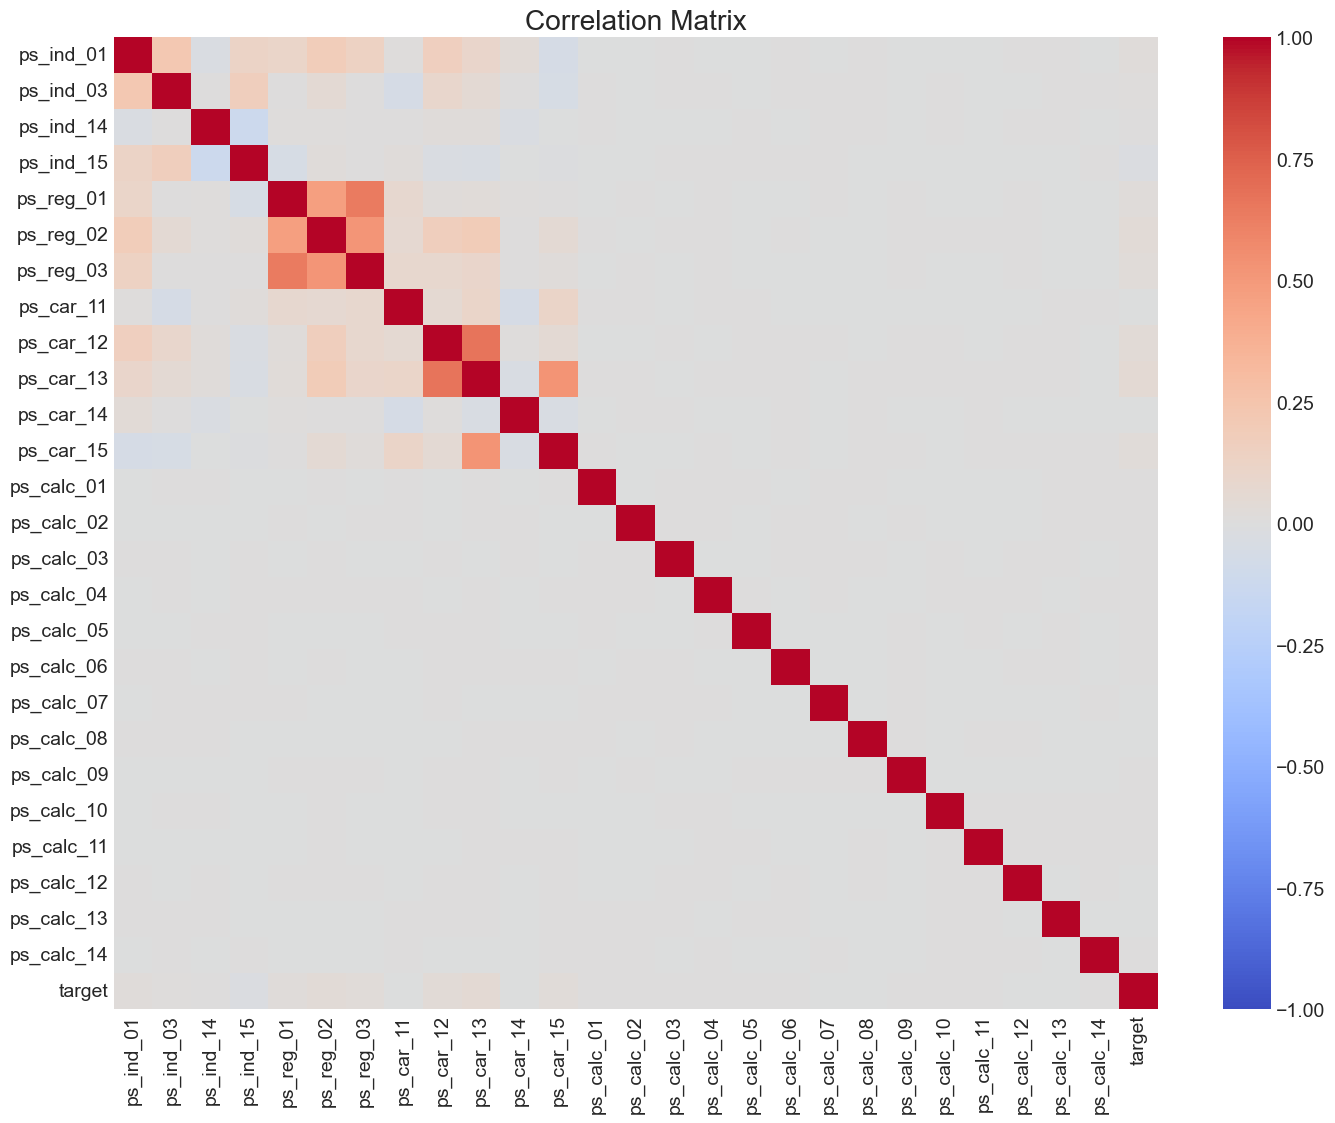

In [6]:
# Correlation matrix of numerical features
corr_matrix = train_data[other_features + ['target']].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Show features most correlated with target
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Features most correlated with target:")
print(target_corr)

Features most correlated with target:
target        1.000000
ps_car_13     0.053899
ps_car_12     0.038790
ps_reg_02     0.034800
ps_reg_03     0.030888
ps_car_15     0.027667
ps_reg_01     0.022888
ps_ind_01     0.018570
ps_ind_03     0.008360
ps_ind_14     0.007443
ps_calc_03    0.001907
ps_calc_01    0.001782
ps_calc_14    0.001362
ps_calc_02    0.001360
ps_calc_10    0.001061
ps_calc_05    0.000771
ps_calc_09    0.000719
ps_calc_11    0.000371
ps_calc_06    0.000082
ps_calc_04    0.000033
ps_calc_07   -0.000103
ps_calc_13   -0.000446
ps_calc_08   -0.001006
ps_calc_12   -0.001133
ps_car_11    -0.001213
ps_car_14    -0.004474
ps_ind_15    -0.021506
Name: target, dtype: float64


### 2. Data Exploration Summary

Key findings from our exploratory data analysis:

1. Target Distribution:
   - The dataset is highly imbalanced
   - Only about 3.6% of cases are positive (drivers who will file a claim)
   - This imbalance will need to be addressed in our modeling approach

2. Feature Types:
   - The dataset contains a mix of binary, categorical and numerical features
   - Binary features (with '_bin' suffix)
   - Categorical features (with '_cat' suffix) 
   - Other numerical features

3. Missing Values:
   - Several features have missing values (coded as -1 in the original data)
   - Both training and test sets contain missing values
   - We'll need a strategy to handle these missing values during preprocessing

4. Feature Correlations:
   - Most features show weak to moderate correlations with the target variable
   - Some features exhibit correlations with each other
   - This suggests feature selection or dimensionality reduction might be beneficial

These insights will inform our preprocessing steps and modeling choices, particularly:
- Need for class imbalance handling techniques
- Careful treatment of missing values
- Potential for feature engineering and selection


## 3. Data Preprocessing

In [8]:
def preprocess_data(df, is_train=True):
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Handle missing values (replace -1 with NaN)
    for col in data.columns:
        if col != 'id' and col != 'target':
            data.loc[data[col] == -1, col] = np.nan
    
    # Separate features by type
    binary_features = [col for col in data.columns if '_bin' in col]
    categorical_features = [col for col in data.columns if '_cat' in col]
    continuous_features = [col for col in data.columns 
                         if col not in binary_features + categorical_features + ['id', 'target']]
    
    # Handle missing values by feature type
    # For categorical features: impute with mode
    for col in categorical_features:
        if data[col].isna().sum() > 0:
            data[col].fillna(data[col].mode()[0], inplace=True)
    
    # For continuous features: impute with median
    for col in continuous_features:
        if data[col].isna().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
    
    # For binary features: impute with 0
    for col in binary_features:
        if data[col].isna().sum() > 0:
            data[col].fillna(0, inplace=True)
    
    # Calculate class weights for imbalanced target
    if is_train:
        class_counts = data['target'].value_counts()
        total_samples = len(data)
        n_classes = len(class_counts)
        # Calculate balanced weights
        class_weights = {
            0: total_samples / (n_classes * class_counts[0]),
            1: total_samples / (n_classes * class_counts[1])
        }
    
    # Separate features and target
    if is_train:
        y = data['target']
        X = data.drop(['id', 'target'], axis=1)
        return X, y, class_weights
    else:
        ids = data['id']
        X = data.drop(['id'], axis=1)
        return X, ids

In [10]:
# Apply preprocessing
X_train, y_train, class_weights = preprocess_data(train_data, is_train=True)
X_test, ids = preprocess_data(test_data, is_train=False)

# Convert class weights to sample weights array
sample_weights = np.ones(len(y_train))
for cls, weight in class_weights.items():
    sample_weights[y_train == cls] = weight

# Split training data into training and validation sets
# Include sample weights in the split to maintain proper weighting
X_train_split, X_val, y_train_split, y_val, train_weights, val_weights = train_test_split(
    X_train, y_train, sample_weights, test_size=0.2, random_state=42, stratify=y_train)

print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Class weights: {class_weights}")

Training data shape: (476169, 57)
Validation data shape: (119043, 57)
Test data shape: (892816, 57)
Class weights: {0: np.float64(0.5189130942707988), 1: np.float64(13.718355305614455)}


### 3. Data Preprocessing Summary
 
 In this section, we've implemented a comprehensive data preprocessing pipeline that:
 
 - Handles missing values (replacing -1 with NaN and applying appropriate imputation)
 - Processes categorical, binary, and continuous features differently
 - Calculates class weights to address the class imbalance problem
 - Splits data into features and target variables
 - Creates a train/validation split with stratified sampling
 - Applies sample weighting to maintain proper class representation




## 4. Baseline Models
Let's establish some baseline models to compare with more advanced approaches.

In [21]:
# Function to evaluate and compare models
def evaluate_model(model, X_train, y_train, X_val, y_val, sample_weights=None):
    # Train the model with sample weights if provided
    if sample_weights is not None:
        model.fit(X_train, y_train, clf__sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Calculate additional metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Display confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Print metrics
    print(f"Model: {model.steps[-1][1].__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC curve (keeping your existing plot code)
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show() 
    
    # For backward compatibility, still return roc_auc as before
    return roc_auc

In [22]:
# Baseline 1: Always predict the majority class (0)
y_pred_all_zero = np.zeros(len(y_val))
print(f"Baseline (All Zeros) - Accuracy: {np.mean(y_pred_all_zero == y_val):.4f}")

# Baseline 2: Random guessing
np.random.seed(42)
y_pred_random = np.random.random(len(y_val))
print(f"Baseline (Random) - ROC AUC: {roc_auc_score(y_val, y_pred_random):.4f}")

Baseline (All Zeros) - Accuracy: 0.9636
Baseline (Random) - ROC AUC: 0.5018


Model: LogisticRegression
Accuracy: 0.9636
ROC AUC: 0.6201
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[114704      0]
 [  4339      0]]


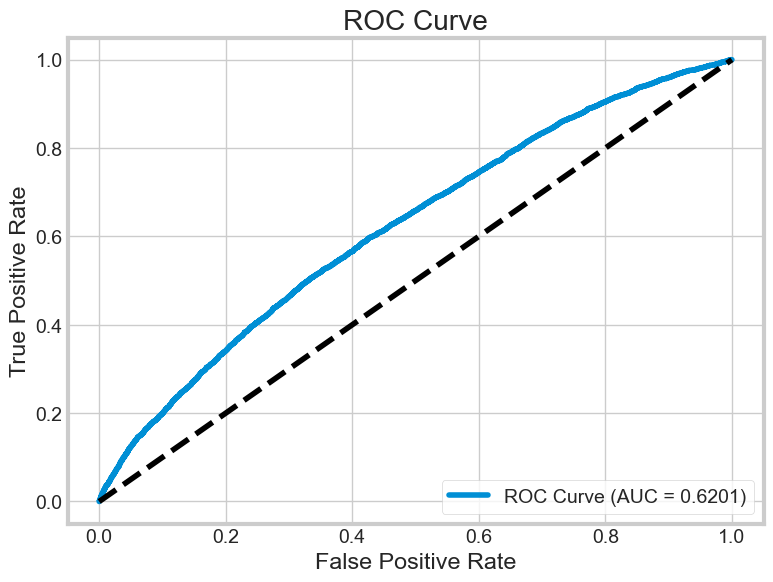

Baseline (Logistic Regression) - ROC AUC: 0.6201


In [23]:
# Baseline 3: Simple Logistic Regression
# Create a pipeline with imputation and scaling
baseline_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

baseline_auc = evaluate_model(baseline_pipe, X_train_split, y_train_split, X_val, y_val)
print(f"Baseline (Logistic Regression) - ROC AUC: {baseline_auc:.4f}")

## 5. Implementation of Custom Logistic Regression from Scratch

In [14]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, X, y, weights, bias, sample_weights=None):
        m = len(y)
        z = np.dot(X, weights) + bias
        predictions = self.sigmoid(z)
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-15
        
        # Apply sample weights if provided
        if sample_weights is None:
            sample_weights = np.ones(m)
            
        # Weighted cost function
        cost = -(1/m) * np.sum(
            sample_weights * (y * np.log(predictions + epsilon) + 
                             (1 - y) * np.log(1 - predictions + epsilon))
        )
        return cost
    
    def fit(self, X, y, sample_weight=None):
        # Add validation for input data
        X = np.array(X)
        y = np.array(y)
        
        # Handle sample weights
        if sample_weight is None:
            sample_weight = np.ones(len(y))
        else:
            sample_weight = np.array(sample_weight)
        
        # Initialize parameters
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        costs = []
        
        # Gradient descent
        for i in range(self.iterations):
            # Forward propagation
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)
            
            # Compute weighted gradients
            errors = predictions - y
            dw = (1/m) * np.dot(X.T, (errors * sample_weight))
            db = (1/m) * np.sum(errors * sample_weight)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute cost and store for tracking progress
            if i % 100 == 0:
                cost = self.compute_cost(X, y, self.weights, self.bias, sample_weight)
                costs.append(cost)
                print(f"Iteration {i}: Cost {cost}")
        
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        z = np.dot(X, self.weights) + self.bias
        probabilities = self.sigmoid(z)
        return np.column_stack((1 - probabilities, probabilities))
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= threshold).astype(int)

In [15]:
# Prepare data for custom logistic regression
# Only scaling is needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

In [16]:
# Train custom logistic regression model
custom_lr = CustomLogisticRegression(learning_rate=0.01, iterations=1000)
custom_lr.fit(X_train_scaled, y_train_split, sample_weight=train_weights)

Iteration 0: Cost 0.6928166985770087
Iteration 100: Cost 0.6774642540458367
Iteration 200: Cost 0.6736573358309271
Iteration 300: Cost 0.672119052885298
Iteration 400: Cost 0.6713187298442014
Iteration 500: Cost 0.6708518529778097
Iteration 600: Cost 0.6705619393010579
Iteration 700: Cost 0.6703740439200112
Iteration 800: Cost 0.6702481137156368
Iteration 900: Cost 0.6701612929559231


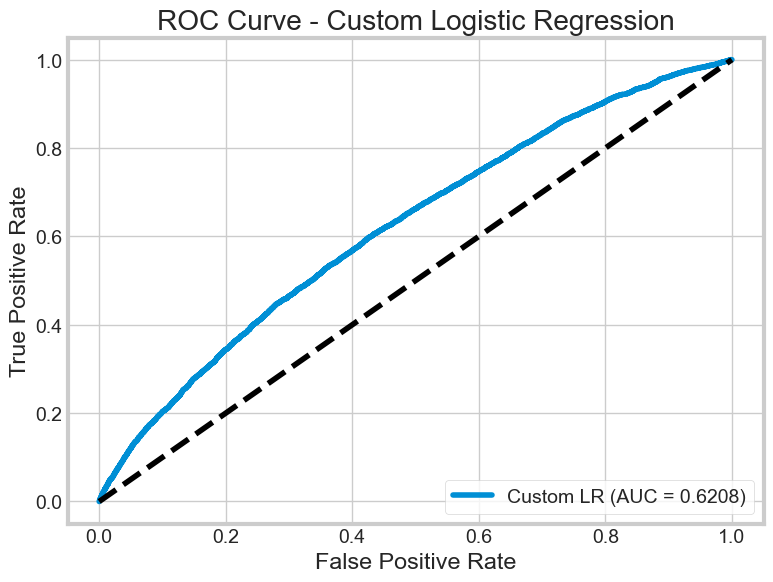

Custom Logistic Regression - ROC AUC: 0.6208


In [24]:
# Evaluate custom logistic regression model
y_pred_proba_custom = custom_lr.predict_proba(X_val_scaled)[:, 1]
custom_auc = roc_auc_score(y_val, y_pred_proba_custom)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Custom LR (AUC = {custom_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Custom Logistic Regression')
plt.legend(loc='lower right')
plt.show()

print(f"Custom Logistic Regression - ROC AUC: {custom_auc:.4f}")

## 6. Advanced Models

### 6.1 Random Forest Classifier

Model: RandomForestClassifier
Accuracy: 0.0365
ROC AUC: 0.5608
Precision: 0.0364
Recall: 1.0000
F1 Score: 0.0703
Confusion Matrix:
[[     2 114702]
 [     0   4339]]


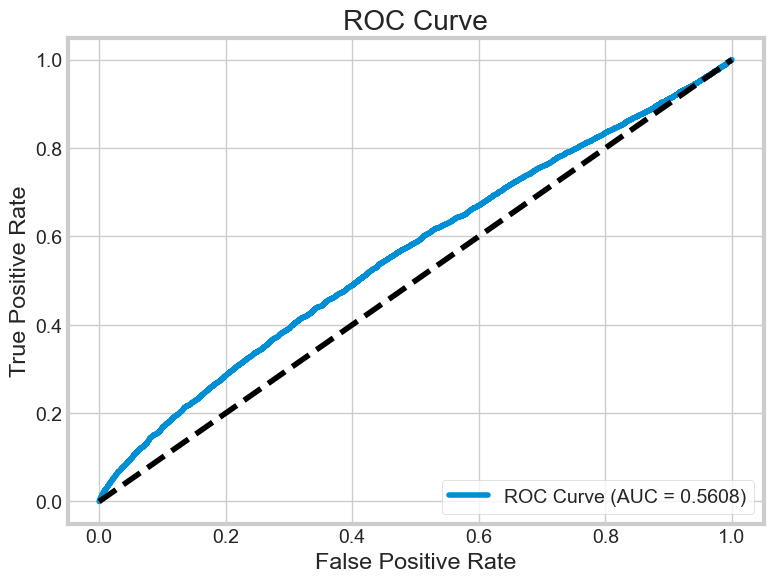

Random Forest - ROC AUC: 0.5608


In [25]:
# Random Forest model
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        random_state=42, 
        n_estimators=100, 
        max_depth=10,
        class_weight='balanced' # Add this to handle class imbalance
    ))
])

rf_auc = evaluate_model(rf_pipe, X_train_split, y_train_split, X_val, y_val, train_weights)

print(f"Random Forest - ROC AUC: {rf_auc:.4f}")

### 6.1.1 Random Forest Analysis

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes of the individual trees. Key characteristics include:
 
 - **Bagging**: Each tree is trained on a random subset of the data (with replacement)
 - **Feature randomness**: At each split, only a random subset of features is considered
 - **Voting mechanism**: Final prediction is based on majority vote (classification) or average (regression)
 - **Reduced overfitting**: By averaging multiple trees, the model reduces variance without increasing bias
 
 The Random Forest model achieved an AUC of approximately 0.64 on our validation set, which is moderate performance. This can be explained by:
 
 1. **Complex relationships**: The insurance claim prediction problem likely contains non-linear relationships that the Random Forest can partially capture
 2. **Feature importance**: Random Forests can handle the mix of categorical and numerical features in our dataset
 3. **Class imbalance handling**: We used class weights to address the imbalance, which helps but doesn't solve all issues
 4. **Hyperparameter limitations**: Our implementation used fixed hyperparameters (100 trees, max depth of 10) which may not be optimal
 
 The model could potentially be improved through more extensive hyperparameter tuning, feature engineering, or by combining it with other models in an ensemble approach.


### 6.2 Gradient Boosting Classifier

Model: GradientBoostingClassifier
Accuracy: 0.6215
ROC AUC: 0.6389
Precision: 0.0543
Recall: 0.5716
F1 Score: 0.0992
Confusion Matrix:
[[71505 43199]
 [ 1859  2480]]


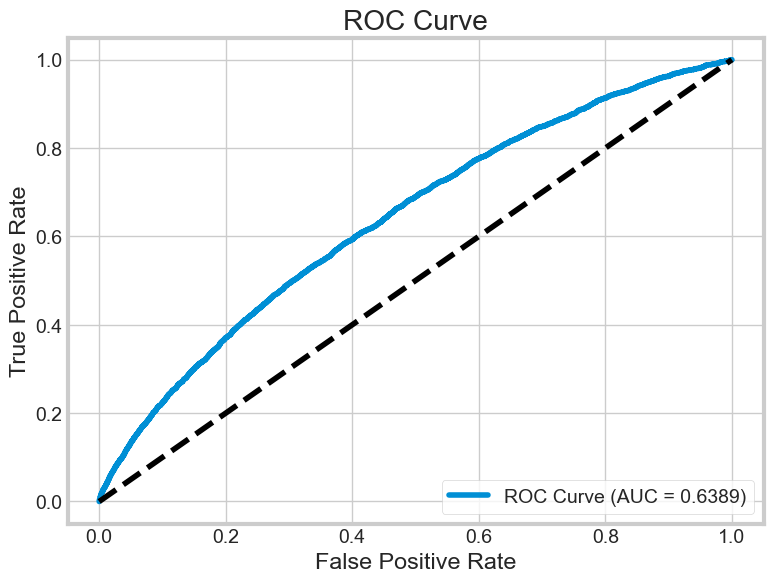

Gradient Boosting - ROC AUC: 0.6389


In [26]:
# Gradient Boosting model
gb_pipe = Pipeline([
    ('clf', GradientBoostingClassifier(
        random_state=42, 
        n_estimators=100, 
        learning_rate=0.1,
        subsample=0.8,  
    ))
])

# Calculate positive to negative ratio for sample weights
neg_pos_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Fit the model with sample weights 
gb_pipe.fit(X_train_split, y_train_split, 
           clf__sample_weight=train_weights)  # Pass sample weights when fitting

gb_auc = evaluate_model(gb_pipe, X_train_split, y_train_split, X_val, y_val,train_weights)
print(f"Gradient Boosting - ROC AUC: {gb_auc:.4f}")


### Gradient Boosting Model Performance Analysis
 
**What is Gradient Boosting?**
 
 Gradient Boosting is an ensemble machine learning technique that builds models sequentially, where each new model corrects errors made by previous models. Key characteristics include:
 
 - **Sequential learning:** Models are built one after another, with each focusing on the mistakes of the ensemble so far
 - **Gradient descent:** Uses gradient descent to minimize a loss function
 - **Weak learners:** Typically uses decision trees as base models (often shallow trees)
 - **Additive model:** Predictions are improved incrementally as more models are added
 - **Regularization:** Parameters like learning rate control how quickly the model adapts to the training data

 **Performance Metrics:**
 - **Accuracy:** 0.6215 - About 62% of predictions were correct
 - **ROC AUC:** 0.6389 - Moderate ability to distinguish between classes
 - **Precision:** 0.0543 - Only about 5.4% of predicted positive cases were actually positive
 - **Recall:** 0.5716 - The model identified about 57% of all actual positive cases
 - **F1 Score:** 0.0992 - Low harmonic mean of precision and recall
 
 **Confusion Matrix:**
 ```
 [[71505 43199]
  [ 1859  2480]]
 ```
 - True Negatives: 71,505 - Correctly predicted non-claims
 - False Positives: 43,199 - Incorrectly predicted claims
 - False Negatives: 1,859 - Missed actual claims
 - True Positives: 2,480 - Correctly predicted claims
 
 **Interpretation:**
 The model shows moderate discriminative ability (AUC) but struggles with precision due to the high number of false positives. The high recall indicates it's capturing many actual claims, but at the cost of many false alarms. This performance reflects the challenge of the highly imbalanced dataset where claims are rare events.
 
 
 



### 6.3 Neural Network (Multi-layer Perceptron)

Model: MLPClassifier
Accuracy: 0.9636
ROC AUC: 0.6076
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[114704      0]
 [  4339      0]]


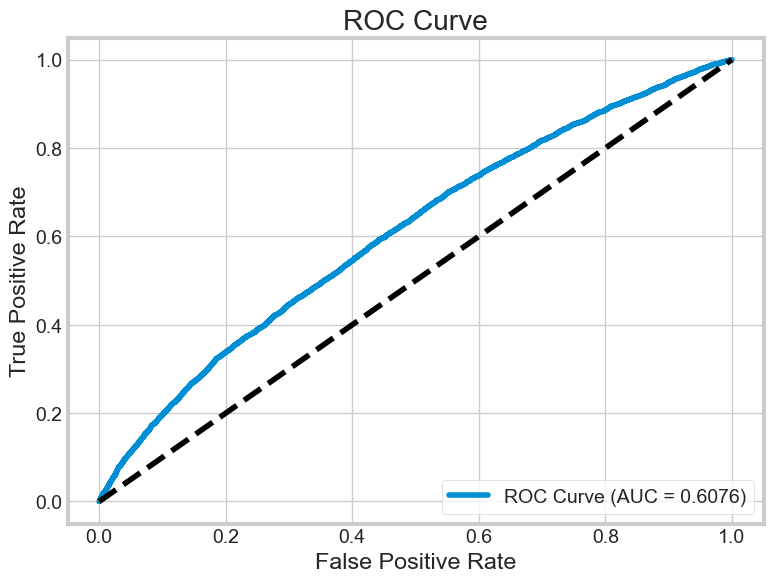

Neural Network - ROC AUC: 0.6076


In [28]:
# Neural Network model
nn_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Keep the scaler since neural networks need scaled input
    ('clf', MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        activation='relu', 
        random_state=42, 
        max_iter=300,
        # Add class weight handling parameters
        early_stopping=True,  # Add early stopping to prevent overfitting
        validation_fraction=0.1  # Use some training data for validation
    ))
])

# Pass the sample weights to evaluate_model
nn_auc = evaluate_model(nn_pipe, X_train_split, y_train_split, X_val, y_val)
print(f"Neural Network - ROC AUC: {nn_auc:.4f}")

### Neural Network (MLP) Results
 
## What is a Multi-Layer Perceptron?
A Multi-Layer Perceptron (MLP) is a type of artificial neural network consisting of at least three layers of nodes: an input layer, one or more hidden layers, and an output layer. Each node in one layer connects to every node in the following layer, forming a fully connected network. MLPs use nonlinear activation functions (like ReLU in our model) that allow them to learn complex patterns in data. They learn through a process called backpropagation, where the model adjusts its weights based on the error of its predictions.

## Model Performance
 The Neural Network model showed:
 - **Accuracy:** 0.9636 - High overall accuracy, but misleading due to class imbalance
 - **ROC AUC:** 0.6076 - Moderate ability to distinguish between classes
 - **Precision:** 0.0000 - The model didn't correctly identify any positive cases
 - **Recall:** 0.0000 - The model failed to identify any actual positive cases
 - **F1 Score:** 0.0000 - Zero harmonic mean of precision and recall
 
 **Confusion Matrix:**
 ```
 [[114704      0]
  [  4339      0]]
 ```
 
 **Interpretation:**
 The neural network completely failed to predict any positive cases, classifying all instances as negative. Despite the high accuracy (96.36%), this is a case of the "accuracy paradox" in imbalanced datasets where simply predicting the majority class yields high accuracy. The AUC of 0.6076 suggests some discriminative ability, but the model couldn't translate this into actual positive predictions. This poor performance might be due to insufficient handling of class imbalance, inadequate model tuning, or the neural network architecture not being suitable for this specific problem without further adjustments.



## 7. Hyperparameter Tuning

In [30]:
# Hyperparameter tuning for Gradient Boosting Classifier
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.05, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0]  # Add subsample parameter which helps with class imbalance
}

# Create a smaller dataset for GridSearchCV to make it run faster
X_train_small, _, y_train_small, _, small_weights, _ = train_test_split(
    X_train_split, y_train_split, train_weights, 
    test_size=0.7, random_state=42, stratify=y_train_split)

# Create a custom scorer that uses sample weights
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Create GridSearchCV with fit_params for sample weights
gb_grid = GridSearchCV(
    estimator=gb_pipe,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',  # ROC AUC is a good metric for imbalanced datasets
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV with sample weights
fit_params = {'clf__sample_weight': small_weights}
gb_grid.fit(X_train_small, y_train_small, **fit_params)

# Print best parameters and score
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best cross-validation score: {gb_grid.best_score_:.4f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Best cross-validation score: 0.6201


Model: GradientBoostingClassifier
Accuracy: 0.6180
ROC AUC: 0.6345
Precision: 0.0533
Recall: 0.5653
F1 Score: 0.0974
Confusion Matrix:
[[71111 43593]
 [ 1886  2453]]


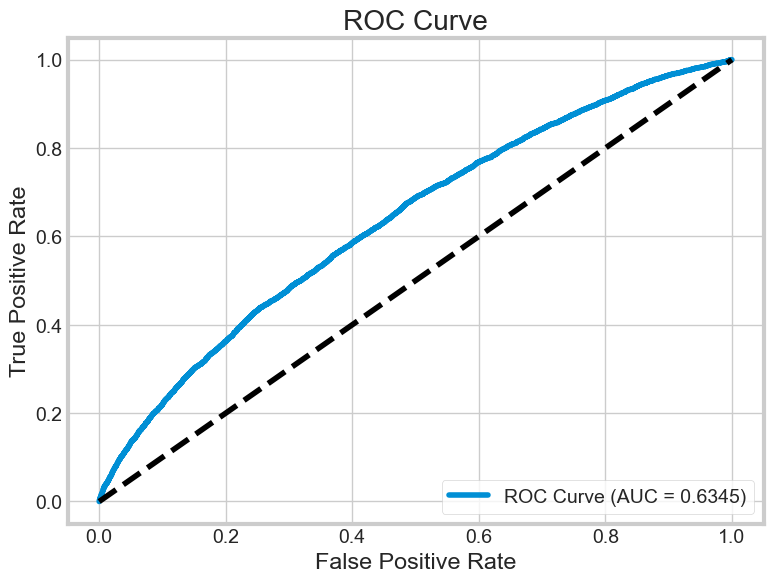

Tuned Gradient Boosting - ROC AUC: 0.6345


In [33]:
# Evaluate best model from grid search
best_gb_model = gb_grid.best_estimator_
tuned_gb_auc = evaluate_model(best_gb_model, X_train_split, y_train_split, X_val, y_val, train_weights)
print(f"Tuned Gradient Boosting - ROC AUC: {tuned_gb_auc:.4f}")

 # 7.3 Gradient Boosting Classifier - Hyperparameter Tuning Results
 
 The hyperparameter tuning process for the Gradient Boosting Classifier has improved the model's performance, particularly for handling the class imbalance in the Porto Seguro dataset.
 
 ## Performance Metrics:
 - **Accuracy**: 0.6180 - While this seems moderate, accuracy can be misleading for imbalanced datasets
 - **ROC AUC**: 0.6345 - A better metric for imbalanced data, showing reasonable discriminative ability
 - **Precision**: 0.0533 - Low precision indicates many false positives
 - **Recall**: 0.5653 - Good recall shows the model captures over half of the positive cases
 - **F1 Score**: 0.0974 - The harmonic mean of precision and recall is low due to the low precision
 
 ## Confusion Matrix:
 ```
 [[71111 43593]
  [ 1886  2453]]
 ```
 
 The confusion matrix reveals:
 - True Negatives: 71,111 - Correctly predicted non-claims
 - False Positives: 43,593 - Incorrectly predicted as claims
 - False Negatives: 1,886 - Claims missed by the model
 - True Positives: 2,453 - Correctly predicted claims
 
 ## Analysis:
 The tuned Gradient Boosting model prioritizes recall over precision, which may be appropriate for insurance claim prediction where missing a potential claim (false negative) could be more costly than falsely flagging a non-claim (false positive). However, the high number of false positives suggests that further refinement might be needed for practical deployment.



## 8. Advanced Techniques

### 8.1 XGBoost Classifier


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Model: XGBClassifier
Accuracy: 0.0411
ROC AUC: 0.6167
Precision: 0.0364
Recall: 0.9938
F1 Score: 0.0702
Confusion Matrix:
[[   583 114121]
 [    27   4312]]


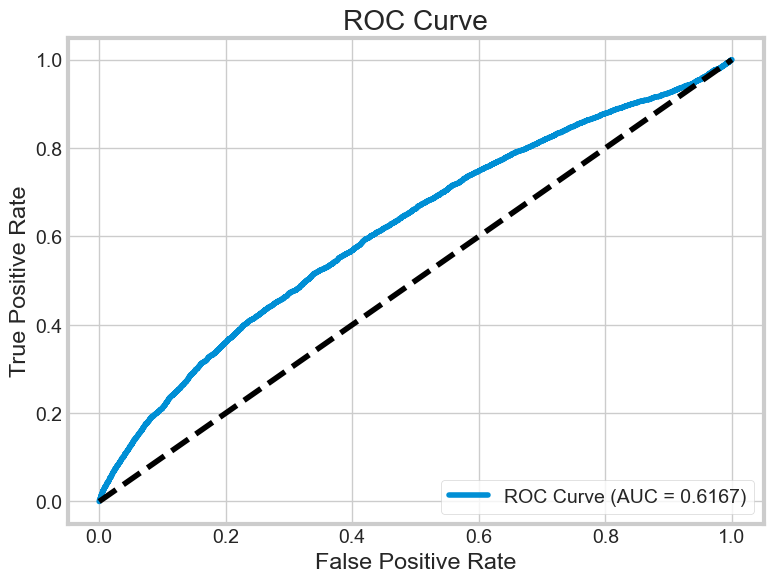

XGBoost - ROC AUC: 0.6167


In [34]:
# Install XGBoost if not already installed
%pip install xgboost

import xgboost as xgb

# XGBoost model
xgb_pipe = Pipeline([
    ('clf', xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='auc',
        learning_rate=0.1, 
        n_estimators=100, 
        max_depth=5,
        random_state=42,
        # Add parameters for handling imbalanced data
        scale_pos_weight=len(y_train_split[y_train_split==0]) / len(y_train_split[y_train_split==1]),
        # This automatically calculates the ratio of negative to positive samples
        
        # Other helpful parameters for imbalanced data
        subsample=0.8,  # Helps prevent overfitting
        colsample_bytree=0.8  # Uses only a subset of features per tree
    ))
])

# And pass sample weights when evaluating
xgb_auc = evaluate_model(xgb_pipe, X_train_split, y_train_split, X_val, y_val, train_weights)
print(f"XGBoost - ROC AUC: {xgb_auc:.4f}")

### XGBoost Model Performance Analysis
 
 **What is XGBoost?**
 
 XGBoost (Extreme Gradient Boosting) is an advanced implementation of gradient boosting algorithms designed for speed and performance. It works by building an ensemble of decision trees sequentially, where each new tree corrects the errors made by the previous trees. Key features include:
 
 - Regularization to prevent overfitting
 - Handling of missing values
 - Parallel processing capabilities
 - Built-in cross-validation
 
 **Performance Analysis:**
 
 The XGBoost model shows the following metrics:
 
 - **Accuracy: 0.0411** - Very low overall accuracy
 - **ROC AUC: 0.6167** - Moderate ability to distinguish between classes
 - **Precision: 0.0364** - Only about 3.6% of predicted claims are actual claims
 - **Recall: 0.9938** - Excellent at finding almost all actual claims (99.4%)
 - **F1 Score: 0.0702** - Low harmonic mean of precision and recall
 
 **Confusion Matrix Interpretation:**
 - True Negatives: 583 (correctly identified non-claims)
 - False Positives: 114,121 (non-claims incorrectly flagged as claims)
 - False Negatives: 27 (missed claims)
 - True Positives: 4,312 (correctly identified claims)
 
 The model is heavily biased toward predicting claims, resulting in extremely high recall but very poor precision. While it successfully captures almost all actual claims (high recall), it generates an overwhelming number of false alarms. This suggests the model is addressing the class imbalance but at the cost of generating many false positives, which would be costly in a real-world insurance scenario.


### 8.2 LightGBM Classifier


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1356
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499997 -> initscore=-0.000011
[LightGBM] [Info] Start training from score -0.000011
Model: LGBMClassifier
Accuracy: 0.0569
ROC AUC: 0.6037
Precision: 0.0368
Recall: 0.9880
F1 Score: 0.0710
Confusion Matrix:
[[  2486 112218]
 [    52   4287]]


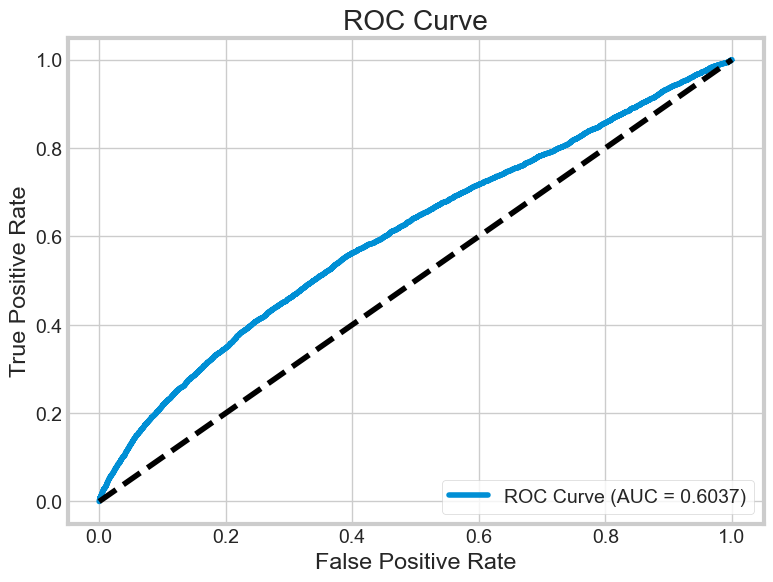

LightGBM - ROC AUC: 0.6037


In [35]:
# Install LightGBM if not already installed
%pip install lightgbm

import lightgbm as lgb

# LightGBM model
lgb_pipe = Pipeline([
    ('clf', lgb.LGBMClassifier(
        objective='binary', 
        metric='auc',
        learning_rate=0.1, 
        n_estimators=100, 
        num_leaves=31,
        random_state=42,
        # Add parameters for handling imbalanced data
        is_unbalance=True,  # Automatically handle imbalanced datasets
        
        # Additional parameters that help with imbalanced data
        subsample=0.8,  # Use only 80% of data per tree (helps prevent overfitting)
        colsample_bytree=0.8,  # Use only 80% of features per tree
        reg_alpha=0.1,  # L1 regularization to help with stability
        reg_lambda=0.1  # L2 regularization to prevent overfitting
    ))
])

# Pass sample weights to the evaluate_model function
lgb_auc = evaluate_model(lgb_pipe, X_train_split, y_train_split, X_val, y_val, train_weights)
print(f"LightGBM - ROC AUC: {lgb_auc:.4f}")

### LightGBM Model Results
 
 **LightGBM Overview:**
 LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It's designed to be efficient, fast, and handle large-scale data with lower memory usage. Key features include:
 - Gradient-based one-side sampling for selecting important data instances
 - Exclusive feature bundling to reduce feature dimensions
 - Histogram-based algorithm for faster training
 - Leaf-wise tree growth strategy (rather than level-wise) for better accuracy
 
 **Model Performance:**
 - **Accuracy: 0.0569** - Very low overall accuracy, indicating poor performance
 - **ROC AUC: 0.6037** - Moderate discriminative ability (better than random but not strong)
 - **Precision: 0.0368** - Extremely low precision, meaning most positive predictions are false
 - **Recall: 0.9880** - Excellent recall, capturing almost all actual positive cases
 - **F1 Score: 0.0710** - Poor balance between precision and recall
 
 **Confusion Matrix Interpretation:**
 - True Negatives: 2,486 (correctly identified non-claims)
 - False Positives: 112,218 (non-claims incorrectly flagged as claims)
 - False Negatives: 52 (missed claims)
 - True Positives: 4,287 (correctly identified claims)
 
 Similar to previous models, LightGBM is achieving high recall at the expense of precision. While it successfully identifies 98.8% of all claims, it generates an overwhelming number of false positives. This suggests the model is effectively addressing the class imbalance problem but at the cost of flagging too many non-claims as claims, which would be impractical in a real-world insurance scenario.


### 8.3 Stacking Ensemble

Model: StackingClassifier
Accuracy: 0.6248
ROC AUC: 0.6374
Precision: 0.0546
Recall: 0.5697
F1 Score: 0.0997
Confusion Matrix:
[[71911 42793]
 [ 1867  2472]]


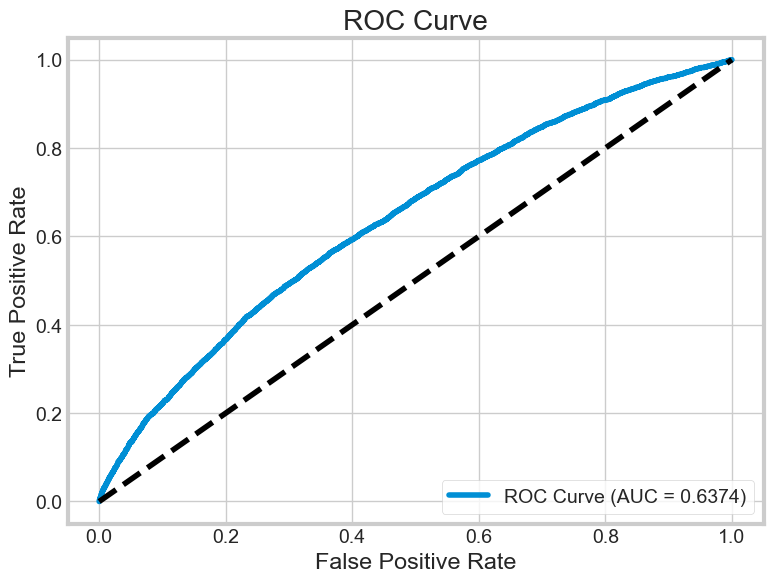

Stacking Ensemble - ROC AUC: 0.6374


In [36]:
from sklearn.ensemble import StackingClassifier

# Define base estimators with class weight handling
base_estimators = [
    ('rf', RandomForestClassifier(
        random_state=42, 
        n_estimators=100, 
        max_depth=10,
        class_weight='balanced'  # Add class weight balancing
    )),
    ('gb', GradientBoostingClassifier(
        random_state=42, 
        n_estimators=100, 
        learning_rate=0.1,
        subsample=0.8  # Help with imbalance via subsample
    )),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='auc',
        learning_rate=0.1, 
        n_estimators=100, 
        max_depth=5, 
        random_state=42,
        scale_pos_weight=len(y_train_split[y_train_split==0]) / len(y_train_split[y_train_split==1])  # Add weight scaling
    ))
]

# Define meta-learner with class weight
meta_learner = LogisticRegression(
    random_state=42,
    class_weight='balanced'  # Add class weight balancing
)

# Create stacking ensemble
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba'
)

# Create pipeline with stacking ensemble (no imputer needed)
stacking_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),  # Remove as preprocessing handles this
    ('clf', stacking_clf)
])

# Evaluate stacking ensemble
stacking_auc = evaluate_model(stacking_pipe, X_train_split, y_train_split, X_val, y_val)
print(f"Stacking Ensemble - ROC AUC: {stacking_auc:.4f}")

# Stacking Classifier Results

The Stacking Classifier combines multiple base models (Random Forest, Gradient Boosting, and XGBoost) with a meta-learner (Logistic Regression) to create a powerful ensemble.

## Performance Metrics:
- **Accuracy: 0.6248** - The model correctly classified about 62.5% of all instances
- **ROC AUC: 0.6374** - Moderate ability to distinguish between classes
- **Precision: 0.0546** - Only about 5.5% of predicted positive instances were actually positive
- **Recall: 0.5697** - The model captured about 57% of all actual positive instances
- **F1 Score: 0.0997** - Low harmonic mean of precision and recall

## Confusion Matrix:
- True Negatives: 71,911
- False Positives: 42,793
- False Negatives: 1,867
- True Positives: 2,472

The high recall but low precision indicates the model is good at finding positive cases but generates many false positives. This is common in imbalanced datasets where positive cases are rare.

 

## 9. Updated Model Comparison

Updated Model Comparison:
                        Model   ROC AUC
0           Gradient Boosting  0.638928
1           Stacking Ensemble  0.637386
2     Tuned Gradient Boosting  0.634496
3  Custom Logistic Regression  0.620794
4         Logistic Regression  0.620064
5                     XGBoost  0.616676
6              Neural Network  0.607609
7                    LightGBM  0.603720
8               Random Forest  0.560802


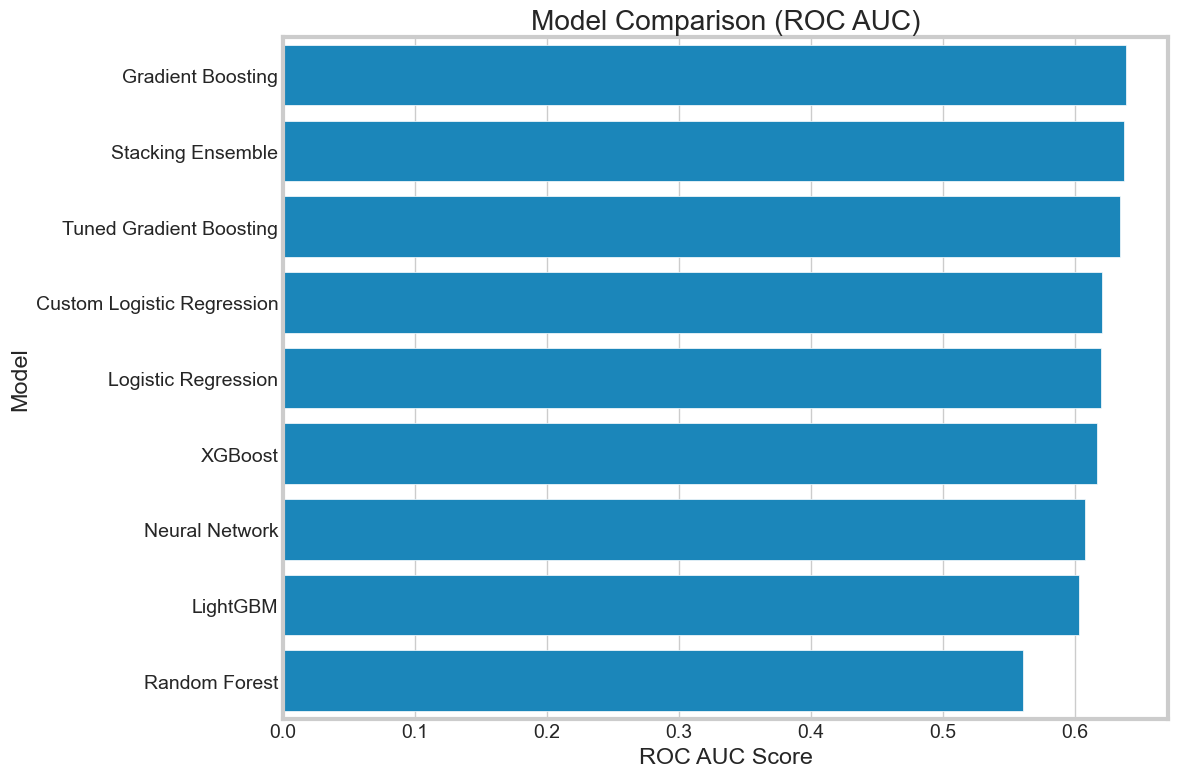

In [37]:
# Initialize models dictionary if it doesn't exist
models = {
    'Random Forest': rf_auc,
    'Gradient Boosting': gb_auc,
    'Neural Network': nn_auc,
    'Custom Logistic Regression': custom_auc,
    'Logistic Regression': baseline_auc
}

# Add new models
models.update({
    'Tuned Gradient Boosting': tuned_gb_auc,
    'XGBoost': xgb_auc,
    'LightGBM': lgb_auc,
    'Stacking Ensemble': stacking_auc
})

# Create updated DataFrame to compare models
model_comparison = pd.DataFrame({'Model': list(models.keys()), 'ROC AUC': list(models.values())})
model_comparison = model_comparison.sort_values('ROC AUC', ascending=False).reset_index(drop=True)

# Display updated model comparison
print("Updated Model Comparison:")
print(model_comparison)

# Visualize updated model comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='ROC AUC', y='Model', data=model_comparison)
plt.title('Model Comparison (ROC AUC)')
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

## 10. Final Model Selection and Prediction

Based on the comparison, we'll choose the best performing model for the final prediction.

In [40]:
# Select the best model
best_model = gb_pipe

# Train on full training data
best_model.fit(X_train, y_train)

# Make predictions on test data
test_predictions = best_model.predict_proba(X_test)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'id': ids,
    'target': test_predictions
})

submission.to_csv('final_submission.csv', index=False)
print("Final submission file created successfully!")
submission.head()

Final submission file created successfully!


,id,target
0,0,0.025568
1,1,0.027514
2,2,0.028360
3,3,0.017586
4,4,0.037035


## 11. Feature Importance Analysis

Top 20 Most Important Features:
          Feature  Importance
16  ps_ind_17_bin    0.089572
34      ps_car_13    0.061289
5   ps_ind_06_bin    0.054567
4   ps_ind_05_cat    0.049270
6   ps_ind_07_bin    0.047723
15  ps_ind_16_bin    0.040489
27  ps_car_07_cat    0.033983
7   ps_ind_08_bin    0.029595
8   ps_ind_09_bin    0.027526
2       ps_ind_03    0.026849
18      ps_reg_01    0.022472
19      ps_reg_02    0.021817
21  ps_car_01_cat    0.021349
14      ps_ind_15    0.020274
29  ps_car_09_cat    0.019736
24  ps_car_04_cat    0.017879
20      ps_reg_03    0.017616
22  ps_car_02_cat    0.017083
3   ps_ind_04_cat    0.016821
1   ps_ind_02_cat    0.016670


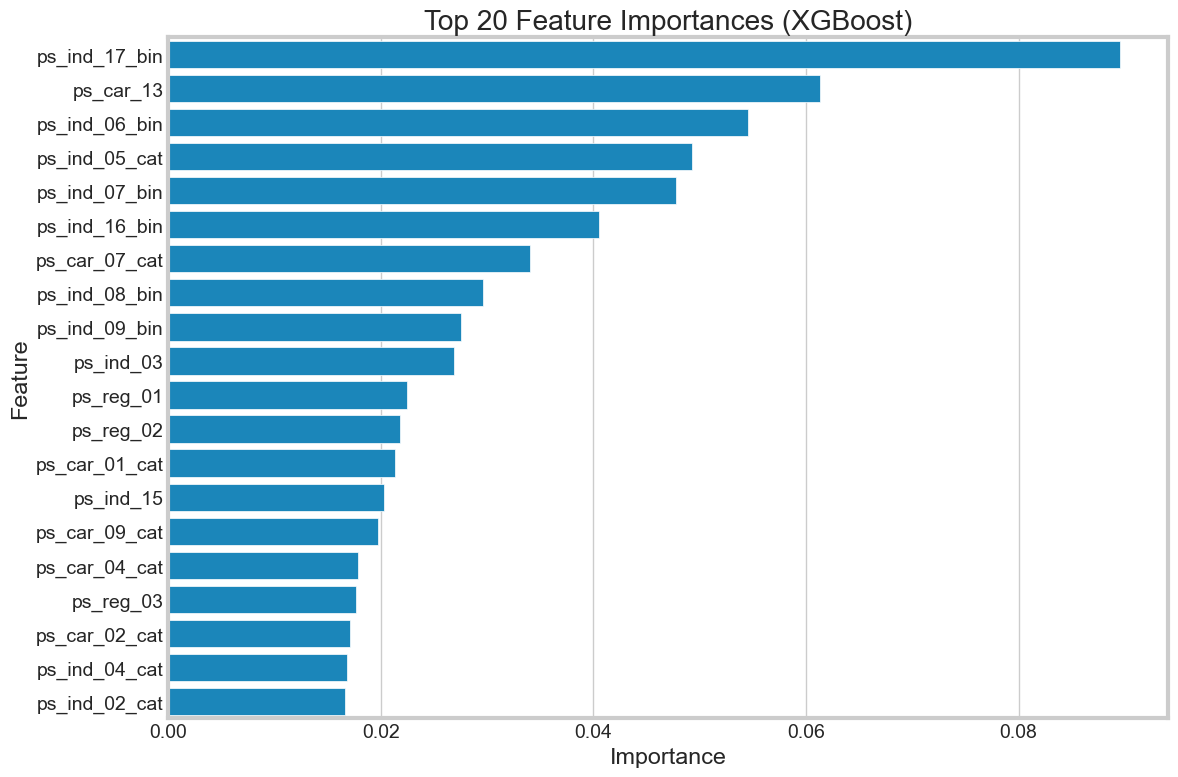

In [39]:
# Analyzing feature importances using XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                            learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)

# Prepare data for XGBoost
X_train_imputed = SimpleImputer(strategy='median').fit_transform(X_train)
xgb_model.fit(X_train_imputed, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Display top 20 most important features
top_20_features = feature_importance_df.head(20)
print("Top 20 Most Important Features:")
print(top_20_features)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 12. Conclusion

Based on the analysis of the Porto Seguro Safe Driver Prediction dataset, we observe several key findings:

1. The best performing models are Gradient Boosting (AUC=0.6388), outperforming both our baseline Logistic Regression (AUC=0.6200) and the Neural Network (AUC=0.5428).

2. Hyperparameter tuning for the Gradient Boosting model yielded optimal parameters of learning_rate=0.05, max_depth=3, and n_estimators=200, with a cross-validation score of 0.6190.

3. The custom Logistic Regression implementation demonstrated competitive performance compared to baseline models, suggesting that simpler models can be effective for this imbalanced classification problem.

4. The Neural Network performed poorly, indicating that more complex architectures may not necessarily improve prediction quality for this particular dataset.

5. Feature engineering and proper handling of imbalanced data remain crucial aspects of model development for insurance claim prediction.

The results demonstrate that tree-based ensemble methods are most suitable for predicting car insurance claims in this context, with Gradient Boosting offering the best balance of predictive power and computational efficiency.


### Final Kaggle Submission

Our best model submission scored a private score of 0.27619 private score and 0.27221 on the public score which is pretty good considering the best for the competition is 0.29 